In [65]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import glob
import torchvision
import torch
import os
from skimage import io
from torch.utils.data import Dataset, DataLoader
from PIL import Image


In [ ]:
from torchvision.models import VGG16_Weights

# READ DATA

In [ ]:
# read label data to check for class balance and weighting
trainpath =  '/content/drive/MyDrive/HackaTUM_Data/dataset/hackatum_dataset/train/*.jpg'
testpath =  '/content/drive/MyDrive/HackaTUM_dataset/dataset/hackatum_dataset/val/*.jpg'

trainpaths = glob.glob(trainpath)
len(trainpaths)

500

In [ ]:
# trainlabels = '/content/drive/MyDrive/HackaTUM_Data/dataset/hackatum_dataset/train/labels.csv'
# testlabels = '/content/drive/MyDrive/HackaTUM_dataset/dataset/hackatum_dataset/val/labels.csv'
# lbldf = pd.read_csv(trainlabels)
# lbldf['label'] = (lbldf['highway'] == 'footway').astype(int)
# display(lbldf.head())
# mean = lbldf['label'].mean()
# print(f'the rateo of the class one over the total is {mean} hence the dataset is balanced')

In [ ]:
trainlabels = '/content/drive/MyDrive/HackaTUM_Data/dataset/hackatum_dataset/train/labels.csv'
testlabels = '/content/drive/MyDrive/HackaTUM_Data/dataset/hackatum_dataset/val/labels.csv'
# def trasform_lbldf(lbldf_path):
#   lbldf = pd.read_csv(lbldf_path)
#   lbldf['label'] = (lbldf['highway'] == 'footway').astype(int)
#   lbldf = lbldf[['image_id','label']]
#   lbldf.to_csv(lbldf_path,index=False)

# trasform_lbldf(trainlabels)
# trasform_lbldf(testlabels)

In [ ]:
lbldf = pd.read_csv(trainlabels)
display(lbldf.head(4))
lbldf = pd.read_csv(testlabels)
display(lbldf.head(4))

,image_id,label
0,102065035753324,1
1,114536350969969,1
2,119878327096719,1
3,120800660045235,1


,image_id,label
0,118033853940785,1
1,142360954539412,0
2,151552926945434,0
3,152113683604813,1


#VGG

In [ ]:
class ImgDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with (img names, labels).
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = pd.read_csv(csv_file, dtype=object)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.labels.iloc[idx, 0]) + '.jpg'
        image = io.imread(img_name)
        if self.transform:
          image = np.array(self.transform(Image.fromarray(image)))
        label = self.labels.iloc[idx, 1]
        sample = {'image': torch.tensor(image,dtype=torch.float), 'label': torch.tensor([int(label)],dtype=torch.float)}

        return sample


In [ ]:
# TAKE PRETRAINED MODEL
from torchvision.models.vgg import vgg16
weights = VGG16_Weights.DEFAULT
model = vgg16(weights=weights)
preprocess = weights.transforms()

In [ ]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# MODIFY MODEL TO FIT OUR DATA
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features=25088, out_features=4096, bias=True),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(in_features=4096, out_features=4096, bias=True),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(in_features=4096, out_features=1, bias=True)
)

In [ ]:
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
#Loaders
traindataset = ImgDataset(trainlabels,'/content/drive/MyDrive/HackaTUM_Data/dataset/hackatum_dataset/train',transform = preprocess)
trainloader = DataLoader(dataset = traindataset, batch_size = 4)
testdataset = ImgDataset(testlabels,'/content/drive/MyDrive/HackaTUM_Data/dataset/hackatum_dataset/val',transform = preprocess)
testloader  = DataLoader(dataset = testdataset, batch_size = 4)

In [ ]:
# Hyperparams
learning_rate = 1e-3
n_epochs = 5
batch_size = 10
num_classes = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loss and optimizers
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

#TRAIN
def train(model, optimizer, criterion, dataloader):
    #accumulated loss across epochs
    acc_loss = 0
    for batch_idx, datas in enumerate(dataloader):
      data = datas['image']
      labels = datas['label']
      print(data.shape)


      data = data.to(device = device)
      labels = labels.to(device = device)
      pred = torch.nn.functional.sigmoid(model(data))
      loss = criterion(pred,labels)
      acc_loss += loss.item()

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()
    return losses
      
#TEST
def test(model,criterion, dataloader):
    #accumulated loss across epochs
    acc_loss = 0
    model.eval()
    with torch.no_grad():
      for batch_idx, datas in enumerate(dataloader):
        data = datas['image']
        labels = datas['label']
        pred = torch.nn.functional.sigmoid(model(input))
        loss = criterion(data, labels)
        acc_loss += loss.item()
    
    return loss

In [ ]:
for epoch in range(1, n_epochs + 1):
    print(f'epoch {epoch}: ')
    print('trainloss: ', train(model, optimizer, criterion, trainloader))
    print('testloss: ',test(model, criterion, testloader))

epoch 1: 
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


KeyboardInterrupt: ignored

DISTANCES: implementation of some back-hand of the app. Some syntetic data is generated (eg: users positions). Additionally we see the API server functions first implementation, you can find more details in the server repo. 

,image_id,longitude,latitude,osm_way_id,highway,taskID
0,173529288004582,11.614302,48.111356,154359841,footway,0
1,187098909929555,11.606248,48.175666,38690109,footway,1
2,216283226982432,11.633299,48.135693,460354029,footway,2
3,269290068323331,11.588134,48.176530,259583217,footway,3
4,305399287917735,11.570784,48.149121,122159109,primary,4
5,308707770748550,11.606785,48.176076,38690109,primary,5
6,310698823750341,11.580631,48.106241,362796882,footway,6
7,315970676772352,11.613351,48.130467,122002285,footway,7
8,334213504878448,11.622674,48.161634,38926857,primary,8
9,387616345626796,11.608646,48.172421,99663070,primary,9


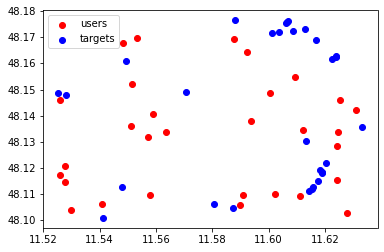

In [ ]:
import matplotlib.pyplot as plt

issuePath = '/content/drive/MyDrive/HackaTUM_Data/dataset/hackatum_dataset/issues/issues.csv'
df = pd.read_csv(issuePath)
df['taskID'] = df.index

display(df)
df = df[['longitude','latitude']]
xmax = df['longitude'].max()
xmin = df['longitude'].min()
ymax = df['latitude'].max()
ymin = df['latitude'].min()
#generate 30 random users
N_users = 30
userIds = np.array(range(N_users))
xusers = np.random.uniform(low=xmin, high=xmax, size=N_users)
yusers = np.random.uniform(low=ymin, high=ymax, size=N_users)

#pd.DataFrame({'id':userIds, 'x':xusers, 'y':yusers}).to_csv('/content/drive/MyDrive/HackaTUM_Data/dataset/hackatum_dataset/issues/users.csv', index = False) 

plt.scatter(xusers, yusers,label = 'users',color = 'red')
xtasks = df['longitude'].values
ytasks = df['latitude'].values
plt.scatter(xtasks, ytasks,label = 'targets',color = 'blue')

plt.legend()
plt.show()

In [87]:
from itertools import islice

#Algorithm of assignement of tasks to users: 
# We need at least one person for a given target => theperson get assigned as task the target for witch the user is the closest
# points are proportional to the distance and to the number of persons assigned to the task
def getUserPosition(userID):
  users = pd.read_csv('/content/drive/MyDrive/HackaTUM_Data/dataset/hackatum_dataset/issues/users.csv')
  return users.iloc[userID]['x'],users.iloc[userID]['y']

def getTaskPosition(taksId):
  tasks = pd.read_csv('/content/drive/MyDrive/HackaTUM_Data/dataset/hackatum_dataset/issues/issues.csv')
  return tasks.iloc[taksId]['longitude'],tasks.iloc[taksId]['latitude']

def getTasksPos():
  df = pd.read_csv('/content/drive/MyDrive/HackaTUM_Data/dataset/hackatum_dataset/issues/issues.csv')
  xtasks = df['longitude'].values
  ytasks = df['latitude'].values
  return xtasks,ytasks

def getUsersPos():
  df = pd.read_csv('/content/drive/MyDrive/HackaTUM_Data/dataset/hackatum_dataset/issues/users.csv')
  xUsers = df['x'].values
  yUsers = df['y'].values
  return xUsers,yUsers

def get_distances(userID,userX,userY,xtasks,ytasks):
  distancesx = [(x-userX)**2 for x in xtasks]
  distancesy = [(y-userY)**2 for y in ytasks]
  distances = [np.sqrt(distancesx[i] + distancesy[i]) for i in range(len(distancesx))] 
  return {(userID,i):distances[i] for i in range(len(distancesx))}

def get_Closest_user(xtasks,ytasks,xUsers,yUsers):
  closest = np.empty(len(xtasks))
  for i in range(len(xtasks)):
    distances = get_distances(i,xtasks[i],ytasks[i],xUsers,yUsers)
    min_index = min(distances, key=distances.get)[1]
    closest[i] = min_index
  return closest



#If user is the closest to a givent task he gets it
# Then user get closest task
def get_N_closest_task_ID(userID,N):
  def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))
  x,y = getUserPosition(userID)
  xtasks,ytasks = getTasksPos()
  distances = get_distances(userID,x,y,xtasks,ytasks)
  sortedItems = dict(sorted(distances.items(), key=lambda item: item[1]))
  return [i[0][1] for i in take(N, sortedItems.items())]

def get_N_closest_task_position(userID,N):
  ids = get_N_closest_task_ID(userID,N)
  xtasks,ytasks = getTasksPos()
  return [(xtasks[i],ytasks[i]) for i in ids]


def getTaskPosition(taksId):
  tasks = pd.read_csv('/content/drive/MyDrive/HackaTUM_Data/dataset/hackatum_dataset/issues/issues.csv')
  return tasks.iloc[taksId]['longitude'],tasks.iloc[taksId]['latitude']

def get_Closest_user(xtasks,ytasks,xUsers,yUsers):
  closest = np.empty(len(xtasks))
  for i in range(len(xtasks)):
    distances = get_distances(i,xtasks[i],ytasks[i],xUsers,yUsers)
    min_index = min(distances, key=distances.get)[1]
    closest[i] = min_index
  return closest

def assignBestTask(userID):
  xtasks,ytasks = getTasksPos()
  xUsers,yUsers = getUsersPos()
  closest = get_Closest_user(xtasks,ytasks,xUsers,yUsers)
  if userID in closest:
    return list(closest).index(userID)
  else:
    return get_N_closest_task_ID(userID,1)

def assignBestTaskPosition(userID):
  Issueid = assignBestTask(userID)
  return getTaskPosition(Issueid)

def getNextStory():
  taksId = randrange(29)
  Longitude, Latitude = getTaskPosition(taksId)
  geolocator = Nominatim(user_agent="geoapiExercises")
  location = geolocator.reverse(str(Latitude)+","+str(Longitude))
  place = ','.join(str(location).split(',')[:2])
  text = pd.read_csv('/content/drive/MyDrive/HackaTUM_Data/dataset/hackatum_dataset/stories.csv')
  curr = int(text.values[0])
  toreturn = text.iloc[curr]
  curr += 1
  if curr > 4:
    text.iloc[0] = str(1)
  else:
    text.iloc[0] = str(curr)
  text.to_csv('/content/drive/MyDrive/HackaTUM_Data/dataset/hackatum_dataset/stories.csv',index = False)
  return toreturn.values[0].replace('*', place)

In [88]:
getNextStory()

'    Here begins our story, in the life of Jack Alden, I will tell you all the information collected by the police by listening to the parties involved in this story. A day like any other, twenty-five years ago, a postman named Jack Alden woke up at his house at 178a, Tegernseer Landstraße, unaware that his day was not going to go as planned.'

In [77]:
getUserPosition(0)

(11.583718278219312, 48.104305203563214)

In [ ]:
get_N_closest_task_ID(0,3)

[18, 6, 0]

In [ ]:
get_N_closest_task_position(0,3)

[(11.5873091, 48.104692400000005),
 (11.5806306, 48.106241100000005),
 (11.61430161647961, 48.111355593621)]

In [86]:
from io import StringIO
str0 = '1'
str1 = 'Here begins our story, in the life of Jack Alden, I will tell you all the information collected by the police by listening to the parties involved in this story. A day like any other, twenty-five years ago, a postman named Jack Alden woke up at his house at *, unaware that his day was not going to go as planned.'
str2 = 'Once he reached the McHenry house to deliver a package at *, Jack parked on the dirt road, accidentally hitting a tire on the garden hose. shortly after getting out of the car, having retrieved the parcel from the trunk and having walked towards the house, Jack noticed the water hose, but he did not give it importance as he heard Mrs. McHencry lying on the floor by the stove.'
str3 = 'Jack rushed to her, he says and was trying to revive her when Mr. McHenry came through the door of the garage. McHenry had taken the day off to water his backyard garden. He had been hosing down his flowerbeds and hedges for half an hour when he noticed the truck in his garage. He walked over to investigate.'
TESTDATA = StringIO("""text;
    1;
    Here begins our story, in the life of Jack Alden, I will tell you all the information collected by the police by listening to the parties involved in this story. A day like any other, twenty-five years ago, a postman named Jack Alden woke up at his house at *, unaware that his day was not going to go as planned.;
    Once he reached the McHenry house to deliver a package at *, Jack parked on the dirt road, accidentally hitting a tire on the garden hose. shortly after getting out of the car, having retrieved the parcel from the trunk and having walked towards the house, Jack noticed the water hose, but he did not give it importance as he heard Mrs. McHencry lying on the floor by the stove.;
    Jack rushed to her, he says and was trying to revive her when Mr. McHenry came through the door of the garage. McHenry had taken the day off to water his backyard garden. He had been hosing down his flowerbeds and hedges for half an hour when he noticed the truck in his garage. He walked over to investigate.;
    Solution: McHenry, while throttling his wife, had been surprised by the arrival of the deliveryman and had hurried to the backyard and his alibi of hosing his garden.  Had he been there all the time, he would have investigated why the water stopped flowing. The truck wheels were parked on the garden hose for "about two minutes," remember?; 
    """)

df = pd.read_csv(TESTDATA, sep=";")['text']
df.to_csv('/content/drive/MyDrive/HackaTUM_Data/dataset/hackatum_dataset/stories.csv',index = False)

In [ ]:
xtasks,ytasks = getTasksPos()
print(xtasks,ytasks)

[11.61430162 11.60624828 11.63329946 11.58813361 11.57078418 11.60678544
 11.5806306  11.61335148 11.62267447 11.60864568 11.5478052  11.62379202
 11.61900312 11.60673963 11.62046124 11.61593237 11.61818098 11.61683318
 11.5873091  11.60369552 11.61529242 11.52520632 11.60141149 11.54952702
 11.61898739 11.62413511 11.54121727 11.61764815 11.61310693 11.52796554] [48.11135559 48.17566584 48.13569263 48.17653048 48.14912076 48.17607553
 48.1062411  48.13046701 48.1616343  48.17242088 48.11291669 48.16265466
 48.1180315  48.1760482  48.12177303 48.11290549 48.11925484 48.16881682
 48.1046924  48.17208671 48.112113   48.14868645 48.17179651 48.16089515
 48.11835267 48.16302274 48.10089803 48.11503274 48.17299008 48.14774795]


In [ ]:
assignBestTask(0)

6

In [ ]:
assignBestTaskPosition(0)

(11.5806306, 48.106241100000005)

In [67]:
len( pd.read_csv('/content/drive/MyDrive/HackaTUM_Data/dataset/hackatum_dataset/issues/issues.csv'))

30

In [72]:
from geopy.geocoders import Nominatim
from random import randrange

taksId = randrange(29)
Longitude, Latitude = getTaskPosition(taksId)
geolocator = Nominatim(user_agent="geoapiExercises")
location = geolocator.reverse(str(Latitude)+","+str(Longitude))
print(','.join(str(location).split(',')[:2]))

Innsbrucker Ring, Ramersdorf
